# Reddit WallStreetBets Posts

**Importing the necessary Libraries**

In [1]:
# To prevent the annoyning Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


sns.set_style('darkgrid')
cmap = sns.cm.mako_r

%matplotlib inline

import re
from nltk import word_tokenize, corpus
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment import SentimentIntensityAnalyzer

import nltk
nltk.download('vader_lexicon')

english_words = set(corpus.words.words())

from IPython.core.display import HTML
HTML("""<style> 
            .output_png { display: table-cell; text-align: center; vertical-align: middle; } 
     </style> """)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tomel\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
reddit = pd.read_csv('Eluvio_DS_Challenge.csv')
reddit.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


**Converting the UTC Unix time to datetime and adding an hour column for each tile**

In [4]:
reddit['time_created'] = pd.to_datetime(reddit['time_created'],unit='s')

reddit['time_created'] = pd.DatetimeIndex(reddit['time_created']).time

reddit['hour'] = reddit['time_created'].astype(str).str[:2].astype(int)

reddit.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category,hour
0,03:34:06,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews,3
1,03:34:35,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews,3
2,03:42:03,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews,3
3,03:54:50,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews,3
4,15:25:20,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews,15


**Which hour we have the most posts of** (8AM PST)

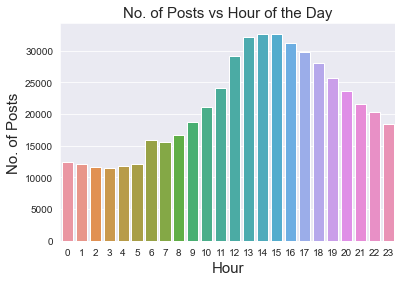

In [5]:
result = reddit.groupby(['hour']).size()

sns.barplot(x = result.index, y = result.values)

plt.title("No. of Posts vs Hour of the Day", fontsize=15)

plt.xlabel("Hour", fontsize=15)
plt.ylabel("No. of Posts", fontsize=15)

plt.show()

---
**Which Day of the week we have most Post** (Tues)

1. We are converting the 'timestamp' to a datetime object
2. Using the weekday() from the datetime object we get the Day of the Week
3. We will plot a barplot using the Seaborn and set the order of days accordingly

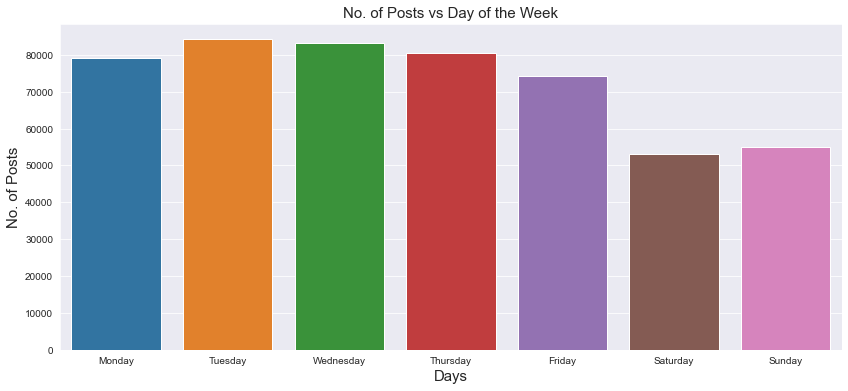

In [6]:
reddit['date_created'] = pd.to_datetime(reddit['date_created'])

day_of_the_week = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
days_order = list(day_of_the_week.values())

reddit['Weekday'] = reddit['date_created'].apply(lambda x : day_of_the_week[x.weekday()])

xs = reddit['Weekday'].value_counts().index
ys = reddit['Weekday'].value_counts().values

plt.figure(figsize=(14,6))

sns.barplot(x=xs, y=ys, order=days_order)

plt.title("No. of Posts vs Day of the Week", fontsize=15)

plt.xlabel("Days", fontsize=15)
plt.ylabel("No. of Posts", fontsize=15)

plt.show()

From the above Barplot we can clearly see that the there were huge number of posts on Tuesday.

---
**Focusing more on the 'title' column of the data**

1. We will preprocess the Text Data in the Title using the clean_text_date().
2. The function will remove Handlers, URLs, Special Characters, Single Characters and Extra Spaces

In [7]:
reddit_title = reddit['title']


def clean_text_date(text):
    text = text.lower()

    # Replacing Handlers with Empty String
    text = re.sub('@[^\s]+','',text)

    # Replacing URLs with Empty String
    text = re.sub(r"http\S+", "",text)

    # Remove all the special characters
    text = ' '.join(re.findall(r'\w+', text))

    # Replacing Single Characters with Empty String
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # Removing Extra Spaces
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    return text

    
# Text Preprocessing
reddit_title = reddit_title.apply(lambda x : clean_text_date(x))

---
**Plotting a Histograms to see the Length(No. of words) Distribution of Title**

1. We use the word_tokenize from nltk on each Title to get a list of Lengths.
2. Then using the Seaborn histplot we plot a histogram. 

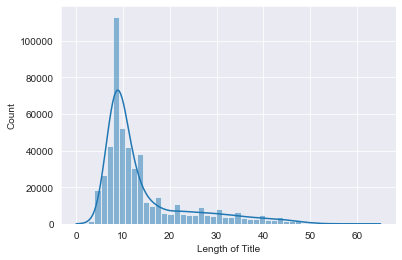

In [8]:
title_length = [len(word_tokenize(text)) for text in reddit_title]

sns.histplot(title_length, bins=50, kde=True)

plt.xlabel("Length of Title")
plt.show()

---
**WordCloud for Title of the Post**

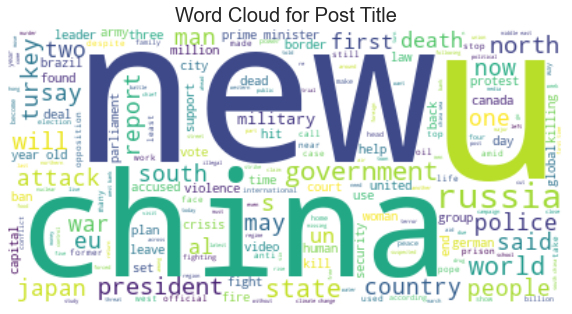

In [9]:
word_tokens = [word_tokenize(text) for text in reddit_title]

word_cloud_string = ""

for word_list in word_tokens:
    for word in word_list:
        if word.lower() in english_words:
            word_cloud_string += word + " "
        
# Updating some of the Words into Stopwords 
description_stopwords = set(STOPWORDS)

my_word_cloud = WordCloud(background_color='white',stopwords=description_stopwords).generate(word_cloud_string)
plt.figure(figsize=(10,20))
plt.imshow(my_word_cloud, interpolation='bilinear')
plt.title("Word Cloud for Post Title", fontsize=20)
plt.axis('off')
plt.show()

---
**Sentiment Analysis Using SentimentIntensityAnalyzer from nltk.sentiment**

1. Calling get_sentiment() on each Title
2. Creating a new Column called 'Sentiment' and storing the respective sentiment
3. Using the Sentiment column to plot various graphs.

In [10]:
def get_sentiment(sia, text):
    if sia.polarity_scores(text)["compound"] > 0:
        return "Positive"
    elif sia.polarity_scores(text)["compound"] < 0:
        return "Negative"
    else:
        return "Neutral"

sia = SentimentIntensityAnalyzer()    
    
reddit_title_df = reddit_title.to_frame(name='Title')
reddit_title_df['Sentiment'] = reddit_title_df['Title'].apply(lambda x : get_sentiment(sia, x))


**Plotting a Bar Graph for Sentiment Counts for the Title**

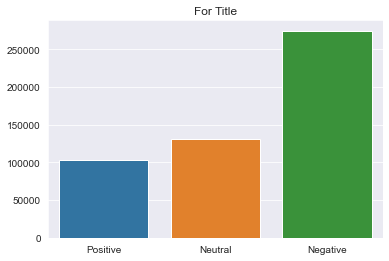

In [11]:
order = ['Positive', 'Neutral', 'Negative']

xs = reddit_title_df['Sentiment'].value_counts().index
ys = reddit_title_df['Sentiment'].value_counts().values
sns.barplot(x=xs, y=ys, order=order)
plt.title("For Title")

plt.show()

---
**WordCloud for Different Sentiments for the Title**

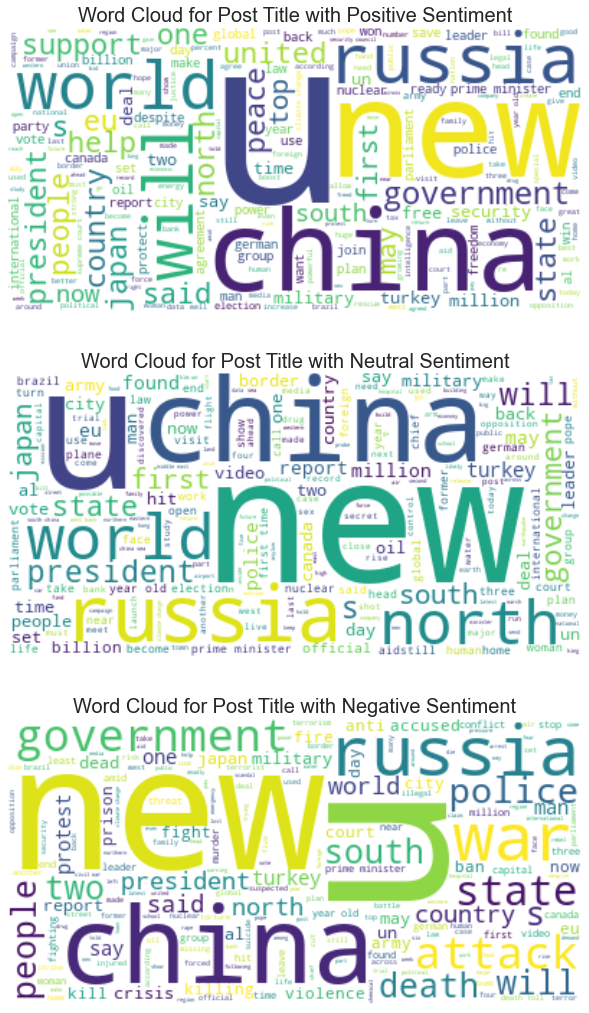

In [12]:
fig, (axis1, axis2, axis3) = plt.subplots(3, 1, figsize=(12,18))

axes = [axis1, axis2, axis3]
sentiments = ['Positive', 'Neutral', 'Negative']

for i in range(3):
    word_tokens = [word_tokenize(text) for text in reddit_title_df[reddit_title_df['Sentiment'] == sentiments[i]]['Title']]
    
    word_cloud_string = ""
    
    for word_list in word_tokens:
        for word in word_list:
            if word.lower() in english_words:
                word_cloud_string += word + " "
    
    description_stopwords = set(STOPWORDS)

    my_word_cloud = WordCloud(background_color='white',stopwords=description_stopwords).generate(word_cloud_string)
    axes[i].imshow(my_word_cloud, interpolation='bilinear')
    axes[i].set_title(f"Word Cloud for Post Title with {sentiments[i]} Sentiment", fontsize=20)
    axes[i].axis('off')


plt.show()